In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
st=time.time()

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
CC = "/content/drive/MyDrive/Soursop/CuttingCaterpillar"
CW = "/content/drive/MyDrive/Soursop/CuttingWeevil"
DB = "/content/drive/MyDrive/Soursop/DieBack"
HE = "/content/drive/MyDrive/Soursop/Healthy"
WF = "/content/drive/MyDrive/Soursop/WhiteFly"
YL = "/content/drive/MyDrive/Soursop/Yellow"

In [ ]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder)
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)

    return image_paths

In [ ]:
img_data = []

for i in [CW,CC,DB,HE,WF,YL]:
    paths = get_path_image(i)
    img_data.extend(paths)
print(len(img_data))

3844


In [ ]:
data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

data = pd.DataFrame(data)

In [ ]:
data["labels"][0:631] = 0 # CuttingWeevils
data["labels"][631:1273] = 1 # CuttingCaterpillars
data["labels"][1273:1925] = 2 # DieBack
data["labels"][1925:2581] = 3 # Healthy
data["labels"][2581:3217] = 4 # WhiteFly
data["labels"][3217:3844] = 5 # Yellow

<ipython-input-8-840b5489e8c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][0:631] = 0 # CuttingWeevils
<ipython-input-8-840b5489e8c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][631:1273] = 1 # CuttingCaterpillars
<ipython-input-8-840b5489e8c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][1273:1925] = 2 # DieBack
<ipython-input-8-840b5489e8c8>:4: SettingWithCopyWarning: 
A valu

In [ ]:
data["labels"] = data["labels"].astype("int64")

#Cropping black edge image

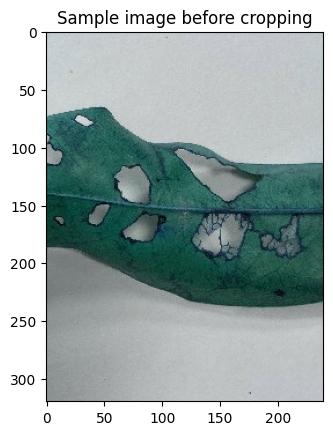

In [ ]:
image = cv.imread(data["img_data"][500])
plt.imshow(image)
plt.title("Sample image before cropping")
plt.show()

In [ ]:
img_list = []
for i in range(len(img_data)):
    image = cv.imread(data["img_data"][i])
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255]
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))
    crop_img = image[mnx:mxx,mny:mxy,:]
    crop_img_r = cv.resize(crop_img, (320,240))
    img_list.append(crop_img_r)

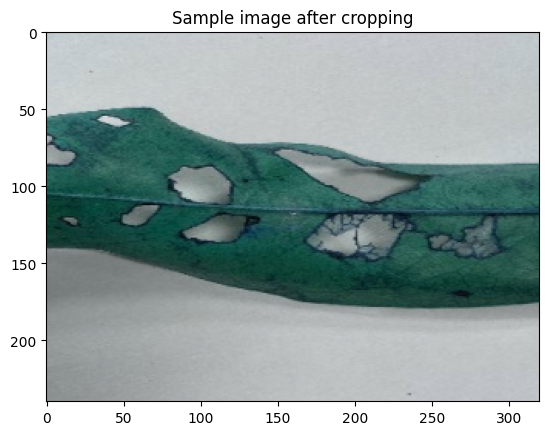

In [ ]:
plt.imshow(img_list[500])
plt.title("Sample image after cropping")
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50, ResNet101
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNetV2
#from transformers import ViTImageProcessor, ViTModel
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
def feature_extract(model):
    if model == "VGG19": model = VGG19(weights='imagenet',include_top=False, pooling="avg")
    elif model == "ResNet50": model = ResNet50(weights='imagenet',include_top=False,pooling="avg")
    elif model == "ResNet101": model = ResNet101(weights='imagenet',include_top=False,pooling="avg")
    elif model == "InceptionV3": model = InceptionV3(weights='imagenet', include_top=False, pooling="avg")
    elif model == "DenseNet121": model = DenseNet121(weights='imagenet', include_top=False, pooling="avg")
    elif model == "MobileNetV2": model = MobileNetV2(weights='imagenet', include_top=False, pooling="avg")
    else:
      raise ValueError("Unsupported model name: " + model)
    return model

In [ ]:
model = feature_extract("ResNet101") # or "VGG19", "ResNet101","InceptionV3","DenseNet121","MobileNetV2"

171446536/171446536 [==============================] - 1s 0us/step


In [ ]:
from PIL import Image

features_list = []
for i in range(len(img_list)):

    image = img_list[i].reshape(-1, 320, 240, 3)
    image = preprocess_input(image)

    """
    # Reshaping when VGG19 model is selected
    features = model.predict(image).reshape(512,)
    """

    #Reshaping  when ResNet50 or ResNet101 model or InceptionV3 is selected 2048
    #for vgg19 shape is 512
    #DenseNet121 shape is 1024
    #MobileNetV2 shape is 1280

    features = model.predict(image).reshape(2048,)

    '''#Only for ViT
    image = img_list[i]
    image = preprocess_input(image)
    image = (image - image.min()) / (image.max() - image.min())  # Rescale to the range [0, 1]

    # Convert to PIL image
    image = (image * 255).astype(np.uint8)
    image = Image.fromarray(image)

    inputs = processor(images=image, return_tensors="pt")

    outputs = model(**inputs)
    features = outputs.last_hidden_state
    features = features.squeeze(0)  # Remove batch dimension'''

    features_list.append(features)

1/1 [==============================] - 0s 53ms/step


In [ ]:
features_df = pd.DataFrame(features_list)

In [ ]:
features_df["labels"] = data["labels"]

In [ ]:
x = features_df.drop(['labels'], axis = 1)
y = features_df.loc[:,"labels"].values

In [ ]:
x

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.532384,0.020933,0.0,0.005321,0.314141,0.271288,0.000000,0.0,8.795093,0.000000,...,0.017429,0.004796,0.000000,0.224623,0.060648,0.014460,0.000000,0.000000,0.039874,0.000000
1,1.059305,0.065368,0.0,0.012816,0.402362,0.019695,0.000000,0.0,9.444772,0.036558,...,0.022487,0.000000,0.098718,0.197033,0.033356,0.004446,0.000000,0.000000,0.176111,0.000000
2,0.860577,0.041774,0.0,0.016609,0.257604,0.020622,0.000000,0.0,9.165537,0.000000,...,0.117168,0.000000,0.022120,0.256652,0.086441,0.010002,0.000000,0.000000,0.061998,0.000000
3,0.685121,0.045968,0.0,0.000000,0.209313,0.855611,0.000000,0.0,8.405336,0.000000,...,0.018082,0.058334,0.002178,0.606498,0.044616,0.006120,0.000000,0.008734,0.124306,0.000000
4,0.828300,0.041010,0.0,0.002820,0.217656,0.518730,0.000000,0.0,8.517613,0.000000,...,0.106297,0.093265,0.001996,0.429320,0.057194,0.000000,0.003266,0.000000,0.148339,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3839,1.510328,0.103385,0.0,0.071559,0.000000,0.207499,0.000000,0.0,7.225522,0.025638,...,0.169488,0.003013,0.018588,0.079381,0.000000,0.000000,0.087201,0.000000,0.224065,0.000000
3840,1.673350,0.309816,0.0,0.088530,0.020684,0.296485,0.000000,0.0,6.833594,0.319149,...,0.270845,0.038909,0.066300,0.100771,0.000000,0.000000,0.096419,0.000000,0.328178,0.116092
3841,1.127290,0.141437,0.0,0.000000,0.000653,0.014441,0.006880,0.0,7.761731,0.000000,...,0.022943,0.094354,0.006377,0.009373,0.000000,0.000000,0.017339,0.000000,1.725452,0.000000
3842,1.010716,0.513779,0.0,0.000000,0.091516,0.003003,0.000000,0.0,6.834849,0.006854,...,0.001100,0.123204,0.010625,0.216645,0.000000,0.000000,0.000000,0.000000,1.396339,0.018568


In [ ]:
print(f"Number of features before feature selection: {x.shape[1]}")

Number of features before feature selection: 2048


In [ ]:
y

array([0, 0, 0, ..., 5, 5, 5])

In [ ]:
ets=time.time()
et=ets-st
print(f"Execution time:{et}s")

Execution time:1325.5309698581696s


#Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x)
x_ = scaler.transform(x)

In [ ]:
x_ = pd.DataFrame(x_)

#Feature Selection Methods

ANOVA

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def anova_fs():

    selector = SelectKBest(f_classif, k=500) # k is number of features
    selector.fit(x_, y)

    cols = selector.get_support(indices=True)
    anova_x = x_[cols]
    return anova_x

Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

def RFE_fs():
    rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=200, step=0.1)
    rfe_selector.fit(x_, y)

    rfe_support = rfe_selector.support_
    rfe_feature = x_.columns[rfe_support]

    rfe_x = x_[rfe_feature]
    return rfe_x

Random Forest

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def rf_fs():
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=5), threshold='1.25*median')
    embeded_rf_selector.fit(x_, y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = x_.loc[:,embeded_rf_support].columns.tolist()

    rf_x = x_[embeded_rf_feature]
    return rf_x

Lasso

In [ ]:
from sklearn.linear_model import LassoCV

def ls_fs():
    lasso_selector = LassoCV(max_iter=5000)
    lasso_selector.fit(x_, y)

    selected_features = x_.columns[lasso_selector.coef_ != 0]
    ls_X = x_[selected_features]

    return ls_X

PCA

In [ ]:
from sklearn.decomposition import PCA

def pca_fs():
    pca = PCA(n_components=500)
    X_pca = pca.fit_transform(x_)
    return X_pca

In [ ]:
fs_x = rf_fs() # feature selection methods "rf_fs", "anova_fs", "RFE_fs","pca_fs(x, n_components=10) ","ls_fs"

In [ ]:
print(f"Number of features after feature selection: {fs_x.shape[1]}")

Number of features after feature selection: 888


Train_Test_split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(fs_x, y, test_size = 0.2, random_state = 42)

#Classification

In [ ]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV

Ensemble

In [ ]:
# Create individual classifiers
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_split=20, n_estimators=99, random_state=0)
svc_classifier = svm.SVC(C=100, gamma=0.1, kernel='poly', probability=True, random_state=0)
nb_classifier = GaussianNB()
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Create a VotingClassifier
vcf = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('svc', svc_classifier),
    ('nb', nb_classifier),
    ('knn', knn_classifier)
])  # You can use 'hard' or 'soft' voting

params = {'voting':['soft'], 'weights':[[1,4,3,1],[1,3,2,1],[1,3,4,1],[1,3,3,2]]}

In [ ]:
vcf_clf = GridSearchCV(vcf, params, cv=5).fit(x_train,y_train)

e_preds = vcf_clf.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, e_preds)

# Print the accuracy
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9948


In [ ]:
p=precision_score(y_test, e_preds, average='weighted')
print('precision : %.3f' % (p))

r=recall_score(y_test, e_preds, average='weighted')
print('recall : %.3f' % (r))

f1=f1_score(y_test, e_preds, average='weighted')
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, e_preds, average='weighted')
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.995
recall : 0.995
f1-score: 0.995
weighted f1-score: 0.995


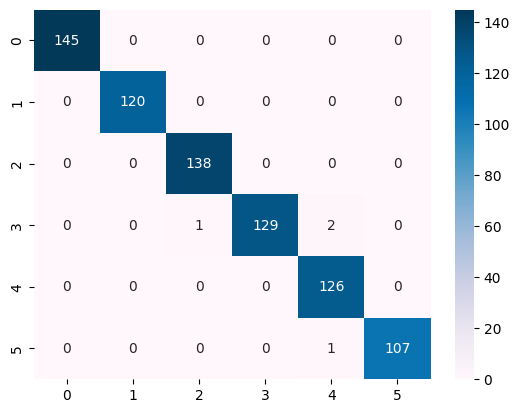

In [ ]:
cf_matrix = confusion_matrix(y_test, e_preds)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

In [ ]:
et=time.time()
et=et-st
print(f"Execution time:{et}s")

Execution time:1536.251536846161s
